## Preprocessing/Merging People and Activities

This script converts features in people and activities into integers, then merges everything into a single table. Makes it easy to drop into classifiers in Sklearn or XGBoost. 

Conveniently, most of the data can be easily encoded to numeric values with simple string splitting. 

Scored ~0.944 with Random Forest Classifier in Sklearn out of the box. 



In [42]:
import numpy as np
import pandas as pd

act_train = pd.read_csv('act_train.csv')
act_test = pd.read_csv('act_test.csv')
people = pd.read_csv('people.csv')

In [2]:
# Save the test IDs for Kaggle submission
test_ids = act_test['activity_id']
train_ids = act_train["activity_id"]

def preprocess_acts(data, train_set=True):
    
    # Getting rid of data feature for now
    data = data.drop(['date', 'activity_id'], axis=1)
    if(train_set):
        data = data.drop(['outcome'], axis=1)
    
    ## Split off _ from people_id
    data['people_id'] = data['people_id'].apply(lambda x: x.split('_')[1])
    data['people_id'] = pd.to_numeric(data['people_id']).astype(int)
    
    columns = list(data.columns)
    
    # Convert strings to ints
    for col in columns[1:]:
        data[col] = data[col].fillna('type 0')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col]).astype(int)
    return data

def preprocess_people(data):
    
    # TODO refactor this duplication
    data = data.drop(['date'], axis=1)
    data['people_id'] = data['people_id'].apply(lambda x: x.split('_')[1])
    data['people_id'] = pd.to_numeric(data['people_id']).astype(int)
    
    #  Values in the people df is Booleans and Strings    
    columns = list(data.columns)
    bools = columns[11:]
    strings = columns[1:11]
    
    for col in bools:
        data[col] = pd.to_numeric(data[col]).astype(int)        
    for col in strings:
        data[col] = data[col].fillna('type 0')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col]).astype(int)
    return data

In [3]:
# Preprocess each df
peeps = preprocess_people(people)
actions_train = preprocess_acts(act_train)
actions_test = preprocess_acts(act_test, train_set=False)

In [4]:
# Merege into a unified table

# Training 
features = actions_train.merge(peeps, how='left', on='people_id')
labels = act_train['outcome']

# Testing
test = actions_test.merge(peeps, how='left', on='people_id')

# Check it out...
features.sample(10)

,people_id,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
908953,25410,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,81
353566,155317,5,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,18
266540,139847,1,7,1,4,1,6,2,2,8,...,0,0,0,0,0,0,0,0,0,0
1393739,330527,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1033662,275084,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,69
984127,266596,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,62
1788668,389974,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7
493258,181073,3,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,64
1232777,301042,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,42
974973,265353,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,50


In [21]:
## Split Training Data
from sklearn.cross_validation import train_test_split

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=num_test, random_state=23)

## Out of box random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.grid_search import GridSearchCV

#clf = RandomForestClassifier(n_estimators = 200, max_features = "log2", min_samples_leaf = 3, n_jobs = 4)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [22]:
## Training Predictions
proba = clf.predict_proba(X_test)
preds = proba[:,1]
score = roc_auc_score(y_test, preds)
print("Area under ROC {0}".format(score))

Area under ROC 0.9867944956439343


In [7]:
from sklearn.externals import joblib
joblib.dump(clf, 'RandomForest.pkl') 

In [8]:
clf = joblib.load('RandomForest.pkl') 

In [25]:
# Test Set Predictions
test_proba = clf.predict_proba(test)
test_preds = test_proba[:,1]

# Format for submission
output = pd.DataFrame({ 'activity_id' : test_ids, 'outcome': test_preds })
output.head()
output.to_csv('XGB_test.csv', index = False)

In [26]:
# Test Set Predictions
test_proba = clf.predict_proba(features)
test_preds = test_proba[:,1]

# Format for submission
output = pd.DataFrame({ 'activity_id' : train_ids, 'outcome': test_preds })
output.head()
output.to_csv('XGB_train.csv', index = False)

In [23]:
import xgboost as xgb

In [19]:
estimator = xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, min_child_weight=3)

In [23]:
estimator.fit(features, labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=200, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [24]:
clf = estimator

In [47]:
from datetime import datetime

In [3]:
test_ids = act_test['activity_id']
train_ids = act_train["activity_id"]

In [43]:
features = act_train.merge(people, how='left', on='people_id')[["date_x", "date_y"]]
test = act_test.merge(people, how='left', on='people_id')[["date_x", "date_y"]]
labels = act_train['outcome']

In [45]:
test.sample()

,date_x,date_y
379570,2022-09-30,2022-01-22


In [48]:
# convert field 'data' into data type
features['date_x'] = features['date_x'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d') )
features['date_y'] = features['date_y'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d') )

test['date_x'] = test['date_x'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d') )
test['date_y'] = test['date_y'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d') )

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000009B17296BA8>>
Traceback (most recent call last):
  File "C:\Users\Егор\Anaconda3\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


In [49]:
# add a couple of new 'date' fields
features['date_year_x'] = features['date_x'].apply(lambda x: x.year)
features['date_month_x'] = features['date_x'].apply(lambda x: x.month)
features['date_day_x'] = features['date_x'].apply(lambda x: x.day)
features['date_weekday_x'] = features['date_x'].apply(lambda x: x.weekday())
features['date_year_y'] = features['date_y'].apply(lambda x: x.year)
features['date_month_y'] = features['date_y'].apply(lambda x: x.month)
features['date_day_y'] = features['date_y'].apply(lambda x: x.day)
features['date_weekday_y'] = features['date_y'].apply(lambda x: x.weekday())

test['date_year_x'] = test['date_x'].apply(lambda x: x.year)
test['date_month_x'] = test['date_x'].apply(lambda x: x.month)
test['date_day_x'] = test['date_x'].apply(lambda x: x.day)
test['date_weekday_x'] = test['date_x'].apply(lambda x: x.weekday())
test['date_year_y'] = test['date_y'].apply(lambda x: x.year)
test['date_month_y'] = test['date_y'].apply(lambda x: x.month)
test['date_day_y'] = test['date_y'].apply(lambda x: x.day)
test['date_weekday_y'] = test['date_y'].apply(lambda x: x.weekday())


In [50]:
features = features.drop(["date_x", "date_y"], axis = 1)
test = test.drop(["date_x", "date_y"], axis = 1)

In [27]:
from sklearn.cross_validation import cross_val_score
%pylab inline

Populating the interactive namespace from numpy and matplotlib


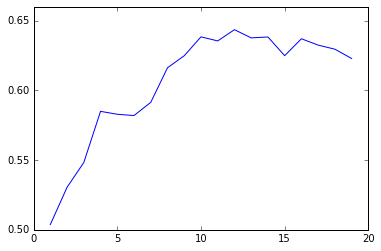

In [28]:
t = np.arange(1,20,1)
scores = []
for i in t:
    estimator = xgb.XGBClassifier(learning_rate=0.2, max_depth=i, n_estimators=10, min_child_weight=3)
    scores.append(np.mean(cross_val_score(estimator, features, labels, scoring = 'roc_auc', cv = 5)))
pylab.plot(t,scores)

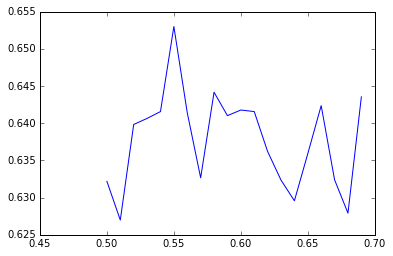

In [32]:
t = np.arange(0.5,0.7,0.01)
scores = []
for i in t:
    estimator = xgb.XGBClassifier(learning_rate=i, max_depth=12, n_estimators=10, min_child_weight=3)
    scores.append(np.mean(cross_val_score(estimator, features, labels, scoring = 'roc_auc', cv = 5)))
pylab.plot(t,scores)

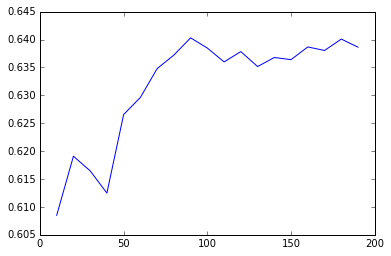

In [33]:
t = np.arange(10,200,10)
scores = []
for i in t:
    estimator = xgb.XGBClassifier(learning_rate=0.55, max_depth=5, n_estimators=i, min_child_weight=3)
    scores.append(np.mean(cross_val_score(estimator, features, labels, scoring = 'roc_auc', cv = 5)))
pylab.plot(t,scores)

In [35]:
t[np.argmax(np.array(scores))]

90

In [36]:
estimator = xgb.XGBClassifier(learning_rate=0.55, max_depth=5, n_estimators=90, min_child_weight=3)
estimator.fit(features, labels)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.55, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=90, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [51]:
test_proba = estimator.predict_proba(test)
test_preds = test_proba[:,1]

# Format for submission
output = pd.DataFrame({ 'activity_id' : test_ids, 'outcome': test_preds })
output.head()
output.to_csv('data_test.csv', index = False)